<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
from mxnet.gluon.loss import L2Loss
import numpy as np
from mxnet import init
import mxnet.gluon.nn as nn
import gym
import matplotlib.pyplot as plt

# Hyper params

In [0]:
BATCH_SIZE = 256          
LR = 0.001                                                       
EPSILON = 0.95                                                
GAMMA = 0.99                                                  
MEMORY_CAPACITY = 1000
l2loss = L2Loss(batch_axis=0)

# env

In [0]:
env_name = 'CartPole-v1'
env = gym.make(env_name)                 
action_dim = env.action_space.n                       
state_dim = env.observation_space.shape[0]

# Q_net

In [0]:
def build_Q_net(net,action_dim):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(action_dim))
  return net

# forward test

In [5]:
state = env.reset()
state = nd.array([state])
print(state)


[[ 0.0201188  -0.04774173 -0.00520396  0.03610527]]
<NDArray 1x4 @cpu(0)>


In [6]:
q = build_Q_net(nn.HybridSequential(),action_dim)
q.initialize(init=init.Xavier())
q.hybridize()
print(q(state))


[[ 0.00651729 -0.01090536]]
<NDArray 1x2 @cpu(0)>


# memory test

In [7]:
s = env.reset()
r = int(1)
a = int(1)
d = True
s_ = env.reset()
transition = np.hstack((s,[a,r,d],s_))
print(transition)

[ 0.03350778 -0.00840883  0.01483599  0.04267589  1.          1.
  1.         -0.03235225  0.02510851 -0.03974916  0.03117604]


# class DQN

In [0]:
class DQN(object):
  def __init__(self,action_dim):
    # initialize eval_net
    self.eval_net = build_Q_net(nn.HybridSequential(),action_dim)
    self.eval_net.initialize()
    self.eval_net.hybridize()
    # initialize memory
    self.memory_counter = 0
    self.memory = np.zeros(shape=(MEMORY_CAPACITY,state_dim*2+3))
    # initialize trainer
    self.trainer = gluon.Trainer(self.eval_net.collect_params(),'Adam',{'learning_rate':LR})

  def choose_action(self,state):
    # best action
    if np.random.uniform() < EPSILON:
      state = nd.array([state])
      action_value = self.eval_net(state)
      action = nd.argmax(action_value,axis=1).asscalar()
      return int(action)
    # random action
    else:
      return np.random.randint(0,action_dim)
  
  def store_transition(self,s,a,r,d,s_):
    transition = np.hstack((s,[a,r,d],s_))
    index = self.memory_counter % MEMORY_CAPACITY
    self.memory[index,:] = transition
    self.memory_counter += 1
  
  def learn(self):
    # sample_index
    sample_index = np.random.choice(MEMORY_CAPACITY,BATCH_SIZE)
    # sample_batch
    b_memory = self.memory[sample_index,:]
    b_s = nd.array(b_memory[:,:state_dim])
    b_a = nd.array(b_memory[:,state_dim:state_dim+1])
    b_r = nd.array(b_memory[:,state_dim+1:state_dim+2])
    b_d = nd.array(b_memory[:,state_dim+2:state_dim+3])
    b_s_= nd.array(b_memory[:,-state_dim:])
    # squeeze
    b_a = nd.squeeze(b_a)
    b_r = nd.squeeze(b_r)
    b_d = nd.squeeze(b_d)
    # caculate gradient
    with mx.autograd.record():
      # Q_sp
      argmax_Q = nd.argmax(self.eval_net(b_s_),axis=1).astype('uint8')
      Q_sp = nd.pick(self.eval_net(b_s_),argmax_Q,axis=1) 
      Q_sp = Q_sp * (nd.ones(BATCH_SIZE) - b_d)
      # Q_s
      Q_s = nd.pick(self.eval_net(b_s),b_a,axis=1)
      # caculate loss
      loss = nd.mean(l2loss(Q_s,(b_r + GAMMA*Q_sp)))
    # loss backward and trainer step
    loss.backward()
    self.trainer.step(1)

0 9.0
10 9.9
20 11.3
30 9.7
40 11.2
50 26.0
60 91.2
70 281.7
76 500.0 464.2


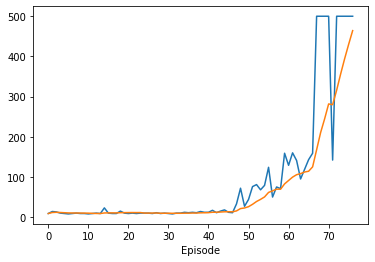

In [9]:
all_rewards = []
avg_rewards = []
dqn = DQN(action_dim)

for episode in range(1000):
  # initialize
  state = env.reset()
  rewards = []
  while True:
    # interactive
    action = dqn.choose_action(state)
    state_ ,reward ,done ,info = env.step(action)
    # logging
    rewards.append(reward) 
    dqn.store_transition(state,action,reward,done,state_)
    # if is time to learn
    if dqn.memory_counter > BATCH_SIZE:
      dqn.learn()
    # if game over
    if done:
      break
    # if game not over
    else:
      state = state_
  
  # record this episode total reward 
  all_rewards.append(np.sum(rewards))
  avg_rewards.append(np.mean(all_rewards[-10:]))
  
  if episode % 10 == 0:
    print(episode,avg_rewards[-1])
  
  if (all_rewards[-1] >= 500)&(avg_rewards[-1] >= 500*0.9):
    print(episode,all_rewards[-1],avg_rewards[-1])
    break

plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.show()

# test

In [10]:
EPSILON = 1
all_rewards = []
for episode in range(10):
  s = env.reset()
  rewards = []
  while True:
    a = dqn.choose_action(s)
    s_ ,r ,done ,info = env.step(a)
    rewards.append(r) 
    if done:
      break
    s = s_ 
  all_rewards.append(np.sum(rewards))
  print(episode,'score',all_rewards[-1])

0 score 500.0
1 score 500.0
2 score 500.0
3 score 500.0
4 score 500.0
5 score 500.0
6 score 500.0
7 score 500.0
8 score 500.0
9 score 500.0
